### Import Statements

In [ ]:
import pandas as pd
from sentence_transformers import CrossEncoder
!pip install -q transformers
import pandas as pd
from transformers import pipeline
import torch
from transformers import RobertaModel, RobertaTokenizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error



/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


### Read articles dataframe in

In [ ]:
df_articles = pd.read_csv("all_teams_data.csv")
df_articles = df_articles.rename(columns={'MetaData': 'Content'})
print((df_articles.head()))

        Team                                              Title  \
0  Air Force  10 reasons why Air Force football will embark ...   
1  Air Force  Air Force hosts Robert Morris to start 2023 se...   
2  Air Force  To keep wins coming, Air Force Falcons face 's...   
3  Air Force  Group of 5 Conferences: Preview and Prediction...   
4  Air Force   Air Force Football Announces New Fan Experiences   

                                             Content  
0                                     URL Not Parsed  
1  Air Force Falcons Game vs Robert Morris Game P...  
2  To keep wins coming, Air Force Falcons face ‘s...  
3  Group of 5 Conferences: Preview and Prediction...  
4  Air Force Academy Athletics Air Force Football...  


### Scrape team results

In [ ]:
import requests
from bs4 import BeautifulSoup

url = 'https://www.sportsoddshistory.com/cfb-win/?y=2023&sa=cfb&t=win&o=t'

response = requests.get(url)
if response.status_code == 200:
    soup = BeautifulSoup(response.content, 'html.parser')

    rows = soup.find_all('tr')

    team_data = []
    for row in rows:
        columns = row.find_all('td')

        if len(columns) >= 6:
            team_name = columns[0].get_text(strip=True)
            win_prediction = columns[1].get_text(strip=True)
            odds_minus = columns[2].get_text(strip=True)
            odds_plus = columns[3].get_text(strip=True)
            adj_win_prediction = columns[4].get_text(strip=True)
            bet_type = columns[5].get_text(strip=True)

            team_data.append({
                'Team': team_name,
                'Win Prediction': win_prediction,
                'Odds Minus': odds_minus,
                'Odds Plus': odds_plus,
                'Actual Win': adj_win_prediction,
                'Bet Type': bet_type
            })

    df_teams = pd.DataFrame(team_data)
    df_teams['Actual Win'] = pd.to_numeric(df_teams['Actual Win'], errors='coerce')
    df_teams['Win Prediction'] = pd.to_numeric(df_teams['Win Prediction'], errors='coerce')

    df_teams['Win Diff'] = df_teams['Actual Win'] - df_teams['Win Prediction']

    print(df_teams)
else:
    print("Failed to retrieve the webpage:", response.status_code)


KeyboardInterrupt: 

In [ ]:
df_all = df_teams.merge(df_articles, on='Team', how='inner')

In [ ]:
print(df_all.columns)

## Filter out bad data

In [ ]:
print((df_all['Content'][1]))

In [ ]:
df_all = df_all[df_all["Content"] != "URL Not Parsed"]

## Filter out irrelevant articles by using the embedding of the title

In [ ]:
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

reference_query = "Looking ahead to football season preview and predictions. Get to know the team. Not past tense"

def get_embedding(text):
    embedding = model.encode([text])
    return embedding

reference_embedding = get_embedding(reference_query)

list_bad_titles = []
avg_embedding = []


def get_similarity(title):
    title_embedding = get_embedding(title)
    similarity_score = cosine_similarity(reference_embedding, title_embedding)[0][0]
    return similarity_score

def adjust_score_based_on_keywords(title, score):
    keywords = ['season', 'preview', 'prediction', 'predictions', 'examining', 'reasons']
    if any(keyword in title.lower() for keyword in keywords):
        score *= 1.5
    if score < 0.15:
        list_bad_titles.append((title, score))
    avg_embedding.append(score)
    return score

df_all['similarity'] = df_all['Title'].apply(lambda title: adjust_score_based_on_keywords(title, get_similarity(title)))

print(f"Mean of the embeddings: {np.mean(avg_embedding)}")
print(len(list_bad_titles))
print(list_bad_titles)


## Perform sentiment Analysis on articles

In [ ]:
import pandas as pd
from transformers import pipeline

counter = 0


sentiment_pipeline = pipeline("sentiment-analysis")
df_all['Sentiment'] = None

def get_sentiment(text):
    result = sentiment_pipeline(text)
    return result[0]['label'], result[0]['score']

def analyze_content_sentiment(content):
    chunk_size = 1000
    num_chunks = (len(content) // chunk_size) + 1
    total_score = 0
    count = 0

    for i in range(num_chunks):
        chunk = content[i * chunk_size: (i + 1) * chunk_size]
        sentiment_label, sentiment_score = get_sentiment(chunk)

        if sentiment_label == 'NEGATIVE':
            sentiment_score *= -1
        total_score += sentiment_score
        count += 1

    avg_sentiment_score = total_score / count if count > 0 else 0
    return avg_sentiment_score

for index, row in df_all.iterrows():
    # if index == 80:
    #   break
    content = row['Content']
    avg_sentiment_score = analyze_content_sentiment(content)
    df_all.at[index, 'Sentiment'] = avg_sentiment_score
    counter += 1
    print(counter)

print(df_all)


In [ ]:
df_all.to_csv("all_teams_data_sentiment.csv")

In [ ]:
df_team_sentiment_avg = df_all.groupby('Team', as_index=False).agg({
    'Sentiment': 'mean',
    'Win Diff': lambda x: x.mode()[0],
    'Bet Type': lambda x: x.mode()[0],
})

df_team_sentiment_avg.rename(columns={'Sentiment': 'Sentiment_Avg'}, inplace=True)

df_team_sentiment_avg = df_team_sentiment_avg.reset_index(drop=True)

for index, row in df_team_sentiment_avg.iterrows():
    # print(row["Bet Type"])
    if row["Bet Type"] != 'Under' and row["Bet Type"] != 'Over':
        df_team_sentiment_avg.drop(index, inplace=True)

df_team_sentiment_avg.to_csv("all_teams_data_sentiment_full.csv")

## LOAD FROM HERE AFTER IMPORTS: Sentiment Analysis DF completed

In [ ]:
df_team_sentiment_avg = pd.read_csv("all_teams_data_sentiment_full.csv")
print(df_team_sentiment_avg)

     Unnamed: 0               Team  Sentiment_Avg  Win Diff Bet Type
0             0          Air Force      -0.276178      -0.5    Under
1             1              Akron      -0.476147      -2.0    Under
2             2            Alabama      -0.219753       1.0     Over
3             3  Appalachian State      -0.021634       1.0     Over
4             4            Arizona      -0.110086       4.0     Over
..          ...                ...            ...       ...      ...
116         116      West Virginia      -0.731522       3.5     Over
117         117   Western Kentucky      -0.234153      -1.5    Under
118         118   Western Michigan      -0.357670       0.5     Over
119         119          Wisconsin      -0.200952      -1.5    Under
120         120            Wyoming      -0.189214       2.0     Over

[121 rows x 5 columns]


In [ ]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

df = df_team_sentiment_avg
X = df[['Sentiment_Avg']]
y = df['Win Diff']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")

Mean Squared Error: 3.3171764072001624
R-squared: -0.02545207213662004


## Show the overall accuracy if making a binary over / under prediction

In [ ]:
from sklearn.metrics import accuracy_score

y_pred_bet = ['Under' if pred < 0 else 'Over' for pred in y_pred]

accuracy = accuracy_score(y_test.apply(lambda x: 'Under' if x < 0 else 'Over'), y_pred_bet)

print(f"Accuracy: {accuracy}")

Accuracy: 0.5135135135135135


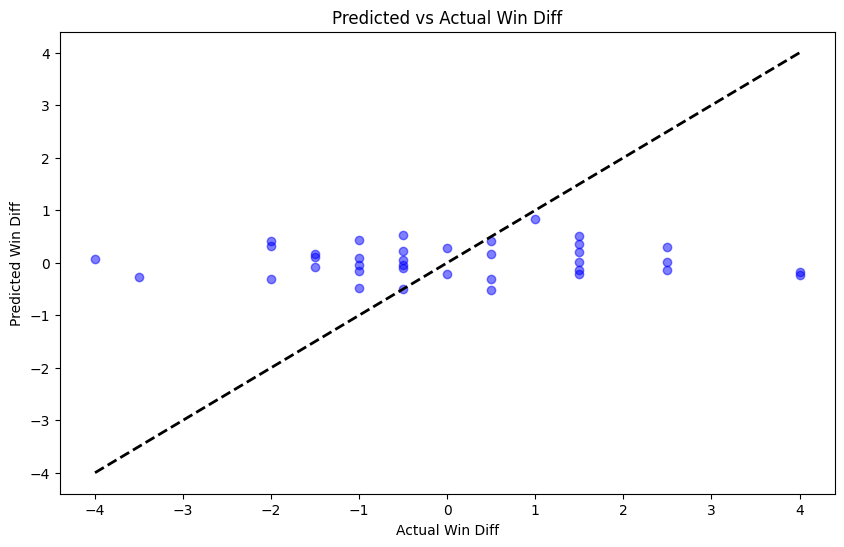

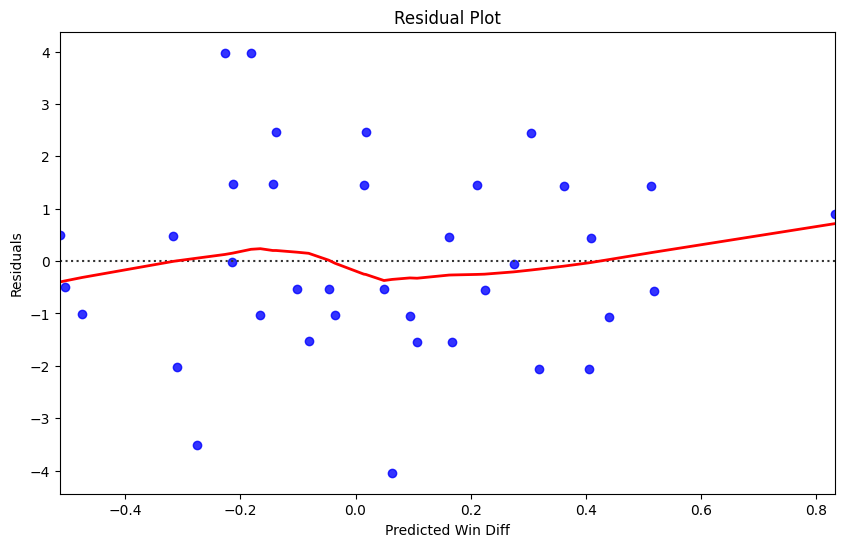

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error

plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.title("Predicted vs Actual Win Diff")
plt.xlabel("Actual Win Diff")
plt.ylabel("Predicted Win Diff")
plt.show()

residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
sns.residplot(x=y_pred, y=residuals, lowess=True, color='blue', line_kws={'color': 'red', 'lw': 2})
plt.title("Residual Plot")
plt.xlabel("Predicted Win Diff")
plt.ylabel("Residuals")
plt.show()


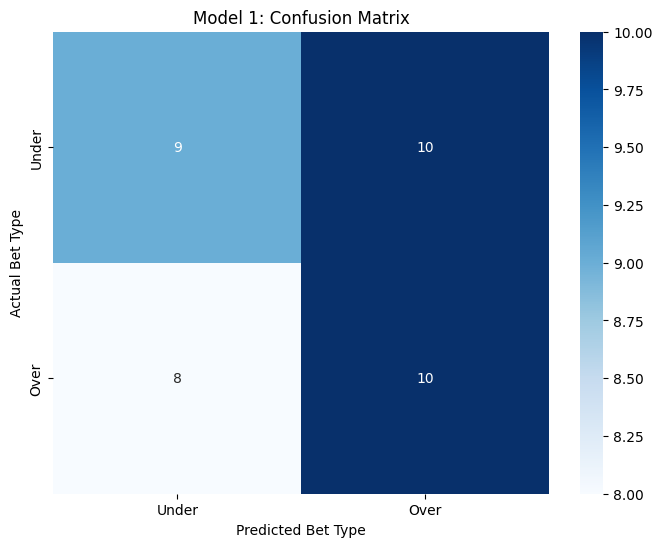

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

y_test_bet = y_test.apply(lambda x: 'Under' if x < 0 else 'Over')
y_pred_bet = ['Under' if pred < 0 else 'Over' for pred in y_pred]

cm = confusion_matrix(y_test_bet, y_pred_bet, labels=['Under', 'Over'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Under', 'Over'], yticklabels=['Under', 'Over'])
plt.xlabel("Predicted Bet Type")
plt.ylabel("Actual Bet Type")
plt.title("Model 1: Confusion Matrix")
plt.show()


## Model number 2: Statistical prediction

### Webscrape ESPN for 2022 statistics (year prior)

### Format returing starters data

In [ ]:
raw_data_returning_starters ="""1. Florida St.
2. Kansas
3. Florida Atlantic
4. Wyoming
5. Michigan
6. Connecticut
7. Texas A&M
8. Boston Coll.
9. Missouri
10. Temple
11. Toledo
12. Northern Illinois
13. South Alabama
14. USC
15. Massachusetts
16. Utah
17. Navy
18. Florida International
19. Texas
20. North Texas
21. Rice
22. Washington
23. Rutgers
24. Syracuse
25. Coastal Carolina
26. Louisiana Tech
27. Wisconsin
28. Auburn
29. Sam Houston
30. Ole Miss
31. Tulane
32. LSU
33. Duke
34. James Madison
35. Miami (FL)
36. Clemson
37. Middle Tennessee State
38. Virginia Tech
39. Nebraska
40. Miami (OH)
41. Indiana
42. UNLV
43. North Carolina
44. Notre Dame
45. Michigan St.
46. California
47. Ga. Tech
48. Ohio St.
49. Boise St.
50. Louisiana
51. UCF
52. Central Michigan
53. Oregon St.
54. Oregon
55. UTEP
56. Penn St.
57. Purdue
58. Vanderbilt
59. UCLA
60. Army
61. New Mexico
62. Colorado St.
63. New Mexico State
64. Texas Tech
65. Maryland
66. West Virginia
67. Iowa St.
68. Memphis
69. Tennessee
70. Brigham Young
71. Illinois
72. J'ville St.
73. Kentucky
74. Akron
75. Eastern Michigan
76. Kansas St.
77. Oklahoma
78. Washington State
79. Marshall
80. Georgia
81. Southern Mississippi
82. Houston
83. Troy
84. Fresno St.
85. Bowling Green State
86. Air Force
87. Minnesota
88. Old Dominion
89. Oklahoma St.
90. Arizona
91. Mississippi State
92. Ball St.
93. Colorado
94. Iowa
95. South Florida
96. Northwestern
97. San Diego State
98. North Carolina State
99. Louisville
100. Baylor
101. Arkansas St.
102. South Carolina
103. Utah St.
104. Liberty
105. Western Kentucky
106. Arkansas
107. Florida
108. Nevada
109. Arizona St.
110. Buffalo
111. San Jose State
112. Wake Forest
113. Louisiana-Monroe
114. Ohio
115. UTSA
116. Virginia
117. SMU
118. TCU
119. Pitt
120. Charlotte
121. Western Michigan
122. Hawaii
123. Ga. Southern
124. Cincinnati
125. Alabama
126. Tulsa
127. UAB
128. Texas St.
129. Stanford
130. East Carolina
131. Appalachian State
132. Georgia St.
133. Kent St."""

returning_starters = []
for line in raw_data_returning_starters.split('\n'):
  temp = line
  temp = temp.replace("St.", 'State')
  temp = temp.replace("Coll", 'College')
  temp = temp.replace('.', ':', 1)
  temp = temp.replace('.', '')
  temp = temp.replace('Ga', 'Georgia')
  temp = temp.replace('GA', 'Georgia')
  temp  = temp.split(':')
  temp[0] = 1 - (int(temp[0]) / 133.01)
  returning_starters.append((temp[1].strip(), temp[0])) ## Team, Percentile (of returning starters)
returning_starters = returning_starters[:len(returning_starters) - 1]
print(returning_starters)

[('Florida State', 0.9924817682880986), ('Kansas', 0.9849635365761973), ('Florida Atlantic', 0.9774453048642959), ('Wyoming', 0.9699270731523946), ('Michigan', 0.9624088414404932), ('Connecticut', 0.9548906097285919), ('Texas A&M', 0.9473723780166905), ('Boston College', 0.9398541463047891), ('Missouri', 0.9323359145928878), ('Temple', 0.9248176828809864), ('Toledo', 0.9172994511690851), ('Northern Illinois', 0.9097812194571837), ('South Alabama', 0.9022629877452824), ('USC', 0.894744756033381), ('Massachusetts', 0.8872265243214796), ('Utah', 0.8797082926095783), ('Navy', 0.8721900608976769), ('Florida International', 0.8646718291857756), ('Texas', 0.8571535974738741), ('North Texas', 0.8496353657619727), ('Rice', 0.8421171340500714), ('Washington', 0.83459890233817), ('Rutgers', 0.8270806706262687), ('Syracuse', 0.8195624389143673), ('Coastal Carolina', 0.812044207202466), ('Louisiana Tech', 0.8045259754905646), ('Wisconsin', 0.7970077437786632), ('Auburn', 0.7894895120667619), ('Sam 

In [ ]:
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)  # Avoid line wrapping
pd.set_option('display.max_colwidth', None)  # Show full content in each column


df_team_stats_offense = pd.read_csv('2022_offensive_stats.csv')
df_team_stats_defense = pd.read_csv('2022_defensive_stats.csv')

In [ ]:
# Rename specific columns for offense
new_columns_offense = df_team_stats_offense.columns.tolist()
new_columns_offense[0] = 'Team Name'
for i in range(1, len(new_columns_offense)):
    new_columns_offense[i] = 'Offense: ' + new_columns_offense[i]
df_team_stats_offense.columns = new_columns_offense

In [ ]:
# Rename specific columns for defense
new_columns_defense = df_team_stats_defense.columns.tolist()
new_columns_defense[0] = 'Team Name'
for i in range(1, len(new_columns_defense)):
    new_columns_defense[i] = 'Defense: ' + new_columns_defense[i]
df_team_stats_defense.columns = new_columns_defense
print(df_team_stats_offense)

                  Team Name  Offense: Passing  Offense: Rushing  Offense: Total Offense  \
0                 Tennessee                13              46.1                    22.3   
1                Ohio State                13              44.2                    21.1   
2                       USC                14              41.4                    24.6   
3                   Alabama                13              41.1                    21.5   
4                   Georgia                15              41.1                    22.4   
5                  Michigan                14              40.4                    17.0   
6                Washington                13              39.7                    28.7   
7                      UCLA                13              39.2                    22.5   
8                    Oregon                13              38.8                    23.7   
9                       TCU                15              38.8                    19.5   

In [ ]:
df_team_stats_full = pd.merge(df_team_stats_offense, df_team_stats_defense, on='Team Name', how='inner')
print(df_team_stats_full.head())

    Team Name  Offense: Passing  Offense: Rushing  Offense: Total Offense  Offense: First Downs  \
0   Tennessee                13              46.1                    22.3                  32.5   
1  Ohio State                13              44.2                    21.1                  31.5   
2         USC                14              41.4                    24.6                  36.8   
3     Alabama                13              41.1                    21.5                  33.7   
4     Georgia                15              41.1                    22.4                  32.9   

   Offense: Penalties  Offense: Turnovers  Offense: Rk  Offense: School  Offense: G  Offense: Pts  \
0                68.7               326.1          2.9             40.2       199.5           5.0   
1                66.8               298.3          3.2             35.8       192.4           5.4   
2                67.0               335.4          3.1             33.8       171.1           5.1   
3

In [ ]:
df_team_stats_full['Returning Starters'] = None

for team, score in returning_starters:
    if team in df_team_stats_full['Team Name'].values:
        df_team_stats_full.loc[df_team_stats_full['Team Name'] == team, 'Returning Starters'] = score
    else:
        print(f"Team not found in DataFrame: {team}")

df_team_stats_full.rename(columns={'Team Name': 'Team'}, inplace=True)


print(df_team_stats_full.head())

Team not found in DataFrame: Sam Houston
Team not found in DataFrame: J'ville State
         Team  Offense: Passing  Offense: Rushing  Offense: Total Offense  Offense: First Downs  \
0   Tennessee                13              46.1                    22.3                  32.5   
1  Ohio State                13              44.2                    21.1                  31.5   
2         USC                14              41.4                    24.6                  36.8   
3     Alabama                13              41.1                    21.5                  33.7   
4     Georgia                15              41.1                    22.4                  32.9   

   Offense: Penalties  Offense: Turnovers  Offense: Rk  Offense: School  Offense: G  Offense: Pts  \
0                68.7               326.1          2.9             40.2       199.5           5.0   
1                66.8               298.3          3.2             35.8       192.4           5.4   
2                6

### Merge the sentiment and statistics tables

In [ ]:
from sklearn.preprocessing import StandardScaler

df_team_sentiment_avg = pd.read_csv("all_teams_data_sentiment_full.csv")
df_sentiment_and_stats = df_team_stats_full

df_sentiment_and_stats = pd.merge(df_team_sentiment_avg, df_team_stats_full, on='Team', how='left')
df_sentiment_and_stats['Returning Starters'] = pd.to_numeric(df_sentiment_and_stats['Returning Starters'], errors='coerce')
df_sentiment_and_stats = df_sentiment_and_stats.drop(columns=['Unnamed: 0'], errors='ignore')

columns_to_normalize = [col for col in df_sentiment_and_stats.columns
                        if df_sentiment_and_stats[col].dtype in ['float64', 'int64']
                        and col not in ['Sentiment_Avg', 'Win Diff']]

df_normalized = df_sentiment_and_stats.dropna(axis=0, how='any').copy()
scaler = StandardScaler()
df_normalized[columns_to_normalize] = scaler.fit_transform(df_normalized[columns_to_normalize])
if 'Returning Starters' in df_normalized.columns:
    df_normalized['Returning Starters'] *= 8
if 'Offense: Total Offense' in df_normalized.columns:
    df_normalized['Offense: Total Offense'] *= 4
if 'Defense: Total Offense' in df_normalized.columns:
    df_normalized['Defense: Total Offense'] *= 4
# print(df_normalized.head())

print(df_normalized.columns)
df_normalized = df_normalized.drop(columns=['Unnamed: 0'], errors='ignore')
X_train, X_test = train_test_split(df_normalized, test_size=0.2, random_state=24)
print(X_train.head())
# Check the split
print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")
# missing_teams = df_sentiment_and_stats[df_sentiment_and_stats['Team'].isna()]

# if not missing_teams.empty:
#     print("Missing Teams (from df_team_stats_full):")
#     for team in missing_teams['Team']:
#         print(team)
# else:
#     print("No teams are missing in the merge.")

Index(['Team', 'Sentiment_Avg', 'Win Diff', 'Bet Type', 'Offense: Passing', 'Offense: Rushing',
       'Offense: Total Offense', 'Offense: First Downs', 'Offense: Penalties',
       'Offense: Turnovers', 'Offense: Rk', 'Offense: School', 'Offense: G', 'Offense: Pts',
       'Offense: Cmp', 'Offense: Att', 'Offense: Pct', 'Offense: TD', 'Offense: Att.1',
       'Offense: Avg', 'Offense: TD.1', 'Offense: Plays', 'Offense: Avg.1', 'Offense: Pass',
       'Defense: Passing', 'Defense: Rushing', 'Defense: Total Offense', 'Defense: First Downs',
       'Defense: Penalties', 'Defense: Turnovers', 'Defense: Rk', 'Defense: School', 'Defense: G',
       'Defense: Pts', 'Defense: Cmp', 'Defense: Att', 'Defense: Pct', 'Defense: TD',
       'Defense: Att.1', 'Defense: Avg', 'Defense: TD.1', 'Defense: Plays', 'Defense: Avg.1',
       'Defense: Pass', 'Returning Starters'],
      dtype='object')
              Team  Sentiment_Avg  Win Diff Bet Type  Offense: Passing  Offense: Rushing  \
98       Texas

Index(['Offense: Passing', 'Offense: Rushing', 'Offense: Total Offense', 'Offense: First Downs',
       'Offense: Penalties', 'Offense: Turnovers', 'Offense: Rk', 'Offense: School', 'Offense: G',
       'Offense: Pts', 'Offense: Cmp', 'Offense: Att', 'Offense: Pct', 'Offense: TD',
       'Offense: Att.1', 'Offense: Avg', 'Offense: TD.1', 'Offense: Plays', 'Offense: Avg.1',
       'Offense: Pass', 'Defense: Passing', 'Defense: Rushing', 'Defense: Total Offense',
       'Defense: First Downs', 'Defense: Penalties', 'Defense: Turnovers', 'Defense: Rk',
       'Defense: School', 'Defense: G', 'Defense: Pts', 'Defense: Cmp', 'Defense: Att',
       'Defense: Pct', 'Defense: TD', 'Defense: Att.1', 'Defense: Avg', 'Defense: TD.1',
       'Defense: Plays', 'Defense: Avg.1', 'Defense: Pass', 'Returning Starters'],
      dtype='object')
Cluster Assignments:


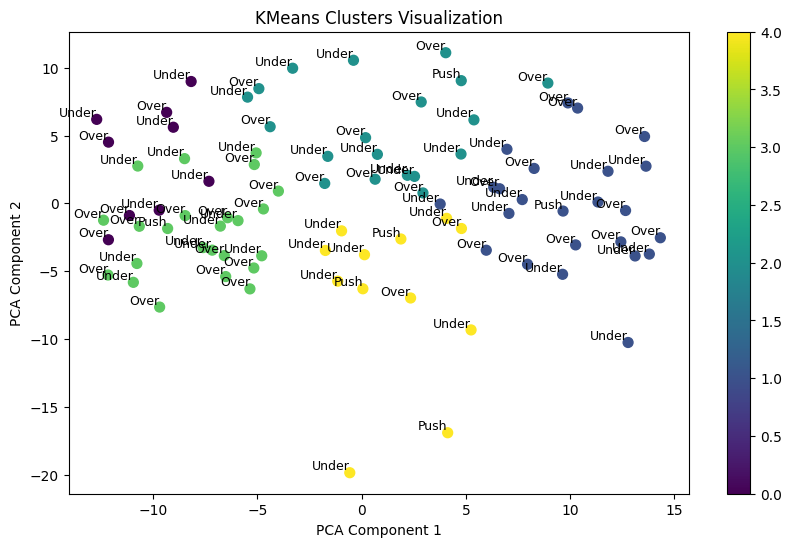

Silhouette Score : 0.153
WCSS (Inertia): 5328.330


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import KMeans


# if 'Defense: First Downs' in X_train.columns:
#     X_train['Defense: First Downs'] *= 2
df_numeric_clean = X_train

df_numeric_only = df_numeric_clean.drop(columns=['Win Diff', 'Team', 'Bet Type'], errors='ignore')

kernel_matrix = rbf_kernel(X, gamma=1.0)

kmeans = KMeans(n_clusters=5, random_state=42)
input_df = df_numeric_only.drop(columns=['Sentiment_Avg', 'Win Diff', 'Cluster', 'Cluster Prob', 'Unnamed: 0'], errors='ignore')
input_df = input_df.loc[:, ~input_df.columns.str.contains('^Unnamed')]
print(input_df.columns)
kmeans.fit(input_df)

df_numeric_clean['Cluster'] = kmeans.labels_

X_train.loc[df_numeric_clean.index, 'Cluster'] = df_numeric_clean['Cluster'].values

print("Cluster Assignments:")

# Reduce dimensions for visualization
pca = PCA(n_components=2)


reduced_data = pca.fit_transform(input_df)

plt.figure(figsize=(10, 6))
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=kmeans.labels_, cmap='viridis', s=50)
plt.colorbar()
plt.title("KMeans Clusters Visualization")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
try:
  for i, team_name in enumerate(X_train['Bet Type']):
      plt.text(reduced_data[i, 0], reduced_data[i, 1], team_name, fontsize=9, ha='right', va='bottom')
except:
  pass
plt.show()

# calc the Silhouette Score
sil_score = silhouette_score(input_df, kmeans.labels_)
print(f"Silhouette Score : {sil_score:.3f}")

# Calculate WCSS (within - Cluster Sum of Squares)
wcss = kmeans.inertia_
print(f"WCSS (Inertia): {wcss:.3f}")


In [ ]:
# Step 12: Assign cluster names to the DataFrame
# You can name the clusters based on their cluster number or analysis
cluster_names = {0: 'Cluster A', 1: 'Cluster B', 2: 'Cluster C', 3: 'Cluster D'}

X_train['Cluster Name'] = X_train['Cluster'].map(cluster_names)
# try:
#   X_train.drop(columns=['Unnamed: 0'], inplace=True)
# except:
#   pass

# Print the updated DataFrame with 'Team Name' and 'Cluster Name'

# print(X_train[['Team', 'Cluster Name']])

In [ ]:
print(input_df.columns)

Index(['Offense: Passing', 'Offense: Rushing', 'Offense: Total Offense', 'Offense: First Downs',
       'Offense: Penalties', 'Offense: Turnovers', 'Offense: Rk', 'Offense: School', 'Offense: G',
       'Offense: Pts', 'Offense: Cmp', 'Offense: Att', 'Offense: Pct', 'Offense: TD',
       'Offense: Att.1', 'Offense: Avg', 'Offense: TD.1', 'Offense: Plays', 'Offense: Avg.1',
       'Offense: Pass', 'Defense: Passing', 'Defense: Rushing', 'Defense: Total Offense',
       'Defense: First Downs', 'Defense: Penalties', 'Defense: Turnovers', 'Defense: Rk',
       'Defense: School', 'Defense: G', 'Defense: Pts', 'Defense: Cmp', 'Defense: Att',
       'Defense: Pct', 'Defense: TD', 'Defense: Att.1', 'Defense: Avg', 'Defense: TD.1',
       'Defense: Plays', 'Defense: Avg.1', 'Defense: Pass', 'Returning Starters'],
      dtype='object')


In [ ]:
# Step 1: Create a list to store the cluster names and win differences for each record
cluster_info = []

# Step 2: Iterate over each record in the DataFrame
for index, row in X_train.iterrows():
    cluster_label = row['Cluster']
    cluster_name = cluster_names.get(cluster_label, 'Unknown')  # Get cluster name by cluster label
    win_diff = row['Win Diff']

    # Append the cluster name and win difference to the list
    cluster_info.append((cluster_name, win_diff))

# Step 3: Add the cluster names to the DataFrame for convenience
X_train['Cluster Name'] = [info[0] for info in cluster_info]

average_win_diff_per_cluster = X_train.groupby('Cluster')['Win Diff'].mean()
average_win_diff_dict = average_win_diff_per_cluster.to_dict()

print(average_win_diff_dict)
print(type(average_win_diff_per_cluster))
# Step 5: Print the average win difference per cluster
print("Average Win Difference per Cluster:")
print(average_win_diff_per_cluster)

# Step 6: Merge the average win difference back to X_train
# We will create a new column 'Avg Win Diff per Cluster' in X_train
# X_train = X_train.merge(average_win_diff_per_cluster, on='Cluster Name', how='left', suffixes=('', '_Cluster'))
X_train['Cluster Prob'] = X_train['Cluster'].map(average_win_diff_dict)


# print(X_train.head())

{0: -0.6666666666666666, 1: 0.10416666666666667, 2: 0.42105263157894735, 3: 0.20833333333333334, 4: -0.4166666666666667}
<class 'pandas.core.series.Series'>
Average Win Difference per Cluster:
Cluster
0   -0.666667
1    0.104167
2    0.421053
3    0.208333
4   -0.416667
Name: Win Diff, dtype: float64


In [ ]:
from sklearn.preprocessing import StandardScaler


# Step 1: Apply the same transformations to X_test (same as X_train)
# Assuming you already fit the scaler to X_train
df_numeric_only_test = X_test.select_dtypes(include=[np.number])  # Keep only numeric columns
# df_numeric_only_test = X_train.dropna(axis=0, how='any')  # Drops rows with any NaN values
df_numeric_only_test = df_numeric_only_test.drop(columns=['Cluster'], errors='ignore')
df_numeric_only_test = df_numeric_only_test.drop(columns=['Cluster Prob'], errors='ignore')
df_numeric_only_test = df_numeric_only_test.drop(columns=['Win Diff', 'Bet Type', 'Cluster Name', 'Team', 'Sentiment_Avg'], errors='ignore')
X_test_scaled = scaler.transform(df_numeric_only_test)  # Apply the same scaling to the test set
# print(X_test_scaled)
# Step 2: Use the KMeans model to predict the clusters for X_test
test_cluster_labels = kmeans.predict(X_test_scaled)

# Step 3: Assign the predicted cluster labels to X_test DataFrame
X_test['Cluster'] = test_cluster_labels  # Add the cluster labels to X_test
X_test['Cluster Prob'] = X_test['Cluster'].map(average_win_diff_dict)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


## Making Predictions simply using K-Means

In [ ]:
X_test_split_with_all_data_k_means = pd.merge(X_test, df_sentiment_and_stats, on='Sentiment_Avg', how='left')
# print(X_test_split_with_all_data_k_means.columns)
matching_count = 0
num_pushes = 0
actuals = []
predictions = []

# # Step 2: Iterate over the DataFrame to check if 'Prediction' and 'Win Diff' have the same sign
for index, row in X_test_split_with_all_data_k_means.iterrows():
    # Get the 'Prediction' and 'Win Diff' values

    prediction_scalar = row['Cluster Prob']
    prediction = None
    if prediction_scalar > 0:
        prediction = "Over"
    elif prediction_scalar < 0:
        prediction = "Under"
    else:
        prediction = "Push"

    # Get the actual 'Win Diff_x' value and determine the label
    win_diff = row['Win Diff_x']
    if win_diff > 0:
        actual = "Over"
    elif win_diff < 0:
        actual = "Under"
    else:
        actual = "Push"

    # Append to the lists
    actuals.append(actual)
    predictions.append(prediction)

    # Check if 'Prediction' and 'Win Diff' have the same sign
    if (prediction == "Over" and win_diff > 0) or (prediction == "Under" and win_diff < 0):
        matching_count += 1  # Increment the counter if the signs match
    if win_diff == 0:
      num_pushes += 1

# # Step 3: Calculate the percentage of matching predictions
total_records = len(X_test_split_with_all_data_k_means) - num_pushes
percentage_matching = (matching_count / total_records) * 100
print(f'Percentage Correct: {round(percentage_matching, 3)}%')

Percentage Correct: 57.143%


## Model 3: Making Predictions Using a random forest

<ipython-input-25-38fc1aa70c4f>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test_split['Prediction'] = prediction_results


Mean Absolute Error: 1.44
R-squared Score: 0.05


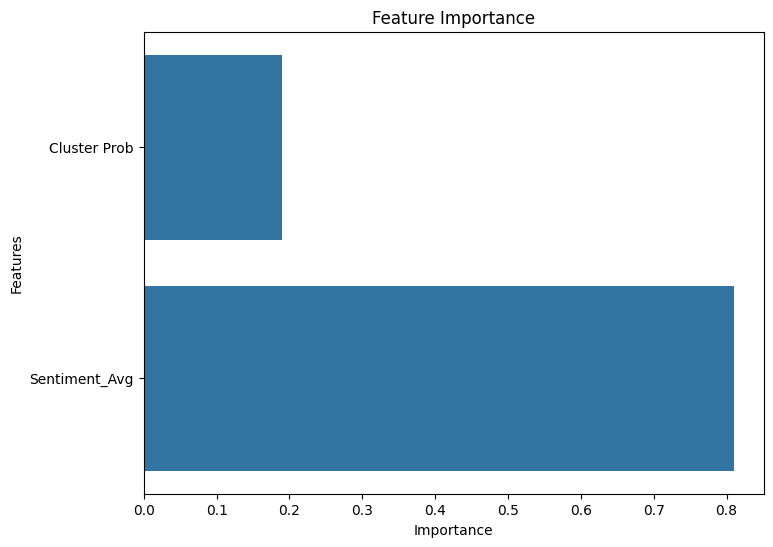

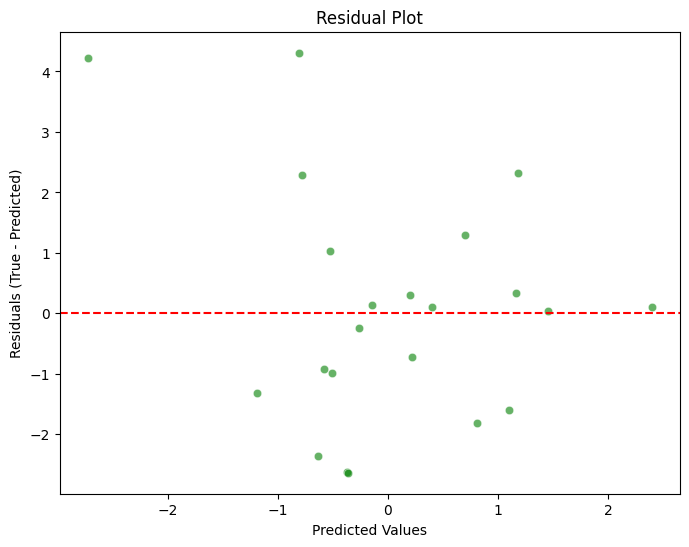

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split

X_train_split = X_train[['Cluster Prob', 'Sentiment_Avg']]  # Features
y_train_split = X_train['Win Diff']  # Target variable

X_test_split = X_test[['Cluster Prob', 'Sentiment_Avg']]  # Features
y_test_split = X_test['Win Diff']
rf_model = RandomForestRegressor(n_estimators=100, random_state=7)

rf_model.fit(X_train_split, y_train_split)

y_pred = rf_model.predict(X_test_split)

prediction_results = []
for pred in y_pred:
    if pred > 0:
        prediction_results.append("Over")
    elif pred < 0:
        prediction_results.append("Under")
    else:
        prediction_results.append("Push")

X_test_split['Prediction'] = prediction_results

mae = mean_absolute_error(y_test_split, y_pred)
r2 = r2_score(y_test_split, y_pred)

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R-squared Score: {r2:.2f}")

# print(X_test_split.head())

# Feature Importance Plot
feature_importances = rf_model.feature_importances_

# Plot feature importances
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances, y=X_train_split.columns)
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

residuals = y_test_split - y_pred

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, color='green', alpha=0.6)
plt.axhline(y=0, color='red', linestyle='--')
plt.title('Residual Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals (True - Predicted)')
plt.show()

# Merging predictions with additional data
X_test_split_with_all_data = pd.merge(X_test_split, df_sentiment_and_stats, on='Sentiment_Avg', how='left')



### See how well it fared making actual predictions

66.66666666666666


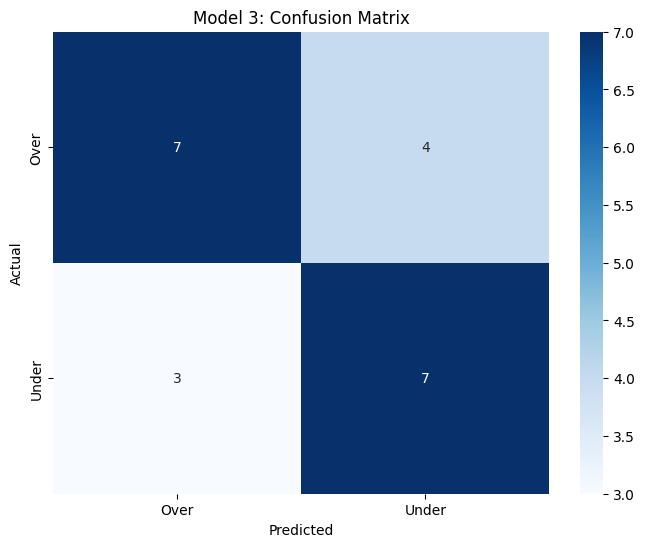

Confusion Matrix:
[[7 4]
 [3 7]]


In [ ]:
matching_count = 0
num_pushes = 0
actuals = []
predictions = []

# # Step 2: Iterate over the DataFrame to check if 'Prediction' and 'Win Diff' have the same sign
for index, row in X_test_split_with_all_data.iterrows():
    # Get the 'Prediction' and 'Win Diff' values
    prediction = row['Prediction']
    win_diff = row['Win Diff']

    # Check if 'Prediction' and 'Win Diff' have the same sign
    if (prediction == "Over" and win_diff > 0) or (prediction == "Under" and win_diff < 0) or (prediction == "Push" and win_diff == 0):
        matching_count += 1  # Increment the counter if the signs match
    if win_diff == 0:
      num_pushes += 1

    if win_diff > 0:
        actual = "Over"
    elif win_diff < 0:
        actual = "Under"
    else:
        actual = "Push"
    actuals.append(actual)
    predictions.append(prediction)


# # Step 3: Calculate the percentage of matching predictions
total_records = len(X_test_split_with_all_data) - num_pushes
percentage_matching = (matching_count / total_records) * 100
print(percentage_matching)

cm = confusion_matrix(actuals, predictions, labels=["Over", "Under"])

# Step 3: Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Over", "Under"], yticklabels=["Over", "Under"])
plt.title("Model 3: Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 4: Print the confusion matrix
print("Confusion Matrix:")
print(cm)